In [4]:
import os
import cv2
import numpy as np
import random
import json
from tqdm import tqdm  # Untuk progress bar

# Folder dataset ikon dan folder untuk background
dataset_dir = 'dataset'
background_dir = 'backgrounds'
output_dir = 'generated_dataset'
annotations_dir = os.path.join(output_dir, 'annotations')
images_dir = os.path.join(output_dir, 'images')

# Buat folder output jika belum ada
os.makedirs(annotations_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

# Jumlah minimal kelas dalam satu gambar
num_classes_per_image = 5
num_images_to_generate = 1000

# Fungsi untuk membuat background dinamis (acak atau polos)
def generate_random_background(width, height):
    if random.random() > 0.5:
        # Buat background warna acak
        background = np.random.randint(0, 255, (height, width, 3), dtype=np.uint8)
    else:
        # Buat background polos dengan warna tertentu
        solid_colors = [
            (0, 0, 0),        # Hitam
            (255, 255, 255),  # Putih
            (128, 128, 128),  # Abu-abu
            (255, 0, 0),      # Merah
            (0, 255, 0),      # Hijau
            (0, 0, 255)       # Biru
        ]
        chosen_color = random.choice(solid_colors)
        background = np.full((height, width, 3), chosen_color, dtype=np.uint8)

    return background

# Fungsi untuk mengecek apakah ada tumpang tindih antara bounding box
def is_overlapping(new_bbox, existing_bboxes):
    for bbox in existing_bboxes:
        if not (new_bbox['xmax'] <= bbox['xmin'] or
                new_bbox['xmin'] >= bbox['xmax'] or
                new_bbox['ymax'] <= bbox['ymin'] or
                new_bbox['ymin'] >= bbox['ymax']):
            return True
    return False

# Fungsi untuk menggabungkan ikon dengan background
def add_icons_to_background(background, icons):
    bg_h, bg_w, _ = background.shape
    bounding_boxes = []

    for icon in icons:
        icon_h, icon_w, _ = icon.shape

        # Resize ikon ke ukuran acak
        scale_factor = random.uniform(0.5, 1.5)  # Ukuran antara 50% hingga 150% dari ukuran aslinya
        new_w = int(icon_w * scale_factor)
        new_h = int(icon_h * scale_factor)
        icon = cv2.resize(icon, (new_w, new_h))

        # Tentukan posisi acak di background dengan pengecekan tumpang tindih
        attempts = 0
        max_attempts = 50

        # Pastikan ikon tidak lebih besar dari background
        if new_w > bg_w or new_h > bg_h:
            new_w = min(new_w, bg_w)
            new_h = min(new_h, bg_h)
            icon = cv2.resize(icon, (new_w, new_h))

        while attempts < max_attempts:
            x_offset = random.randint(0, bg_w - new_w)
            y_offset = random.randint(0, bg_h - new_h)

            new_bbox = {
                'xmin': x_offset,
                'ymin': y_offset,
                'xmax': x_offset + new_w,
                'ymax': y_offset + new_h
            }

            # Jika tidak ada tumpang tindih, tambahkan ikon
            if not is_overlapping(new_bbox, bounding_boxes):
                background[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = icon
                bounding_boxes.append(new_bbox)
                break
            attempts += 1

    return background, bounding_boxes

# Fungsi untuk menyimpan anotasi bounding box dalam format JSON
def save_annotation(annotation_data, annotation_path):
    with open(annotation_path, 'w') as f:
        json.dump(annotation_data, f, indent=4)

# Loop untuk membuat 1000 dataset
for i in tqdm(range(num_images_to_generate)):
    # Pilih background
    if os.path.exists(background_dir) and len(os.listdir(background_dir)) > 0:
        background_name = random.choice(os.listdir(background_dir))
        background_path = os.path.join(background_dir, background_name)
        background = cv2.imread(background_path)
    else:
        # Buat background acak jika tidak ada background di folder
        background = generate_random_background(800, 600)

    # Pilih ikon dari minimal 5 kelas berbeda
    class_names = random.sample(os.listdir(dataset_dir), num_classes_per_image)
    icons = []
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        image_name = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, image_name)
        icon = cv2.imread(image_path)
        icons.append(icon)

    # Gabungkan ikon-ikon dengan background
    combined_image, bboxes = add_icons_to_background(background, icons)

    # Simpan gambar hasil
    image_filename = f'image_{i:04d}.jpg'
    image_path = os.path.join(images_dir, image_filename)
    cv2.imwrite(image_path, combined_image)

    # Buat anotasi untuk gambar ini
    annotation_data = {
        'image': image_filename,
        'bboxes': [],
        'classes': []
    }
    
    for bbox, class_name in zip(bboxes, class_names):
        annotation_data['bboxes'].append(bbox)
        annotation_data['classes'].append(class_name)

    # Simpan anotasi
    annotation_filename = f'annotation_{i:04d}.json'
    annotation_path = os.path.join(annotations_dir, annotation_filename)
    save_annotation(annotation_data, annotation_path)

print(f"Dataset selesai di-generate! Terdapat {num_images_to_generate} gambar dan anotasi.")


100%|██████████| 1000/1000 [00:15<00:00, 64.29it/s]

Dataset selesai di-generate! Terdapat 1000 gambar dan anotasi.


In [8]:
import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

def get_faster_rcnn_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one (for your custom number of classes)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model


class IconDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.image_files = list(sorted(os.listdir(images_dir)))
        self.annotation_files = list(sorted(os.listdir(annotations_dir)))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load images and annotations
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        annotation_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        
        # Open the image
        image = Image.open(image_path).convert("RGB")
        
        # Load the annotations (assuming COCO format, or adjust this part to your format)
        # You might need to write custom logic here to load your annotations
        # Example: loading annotations as a dict with bounding boxes and labels
        target = self.load_annotation(annotation_path)
        
        if self.transforms:
            image = self.transforms(image)

        return image, target

    def load_annotation(self, annotation_path):
        # Custom logic to load your annotation
        # You can parse a JSON, XML, or whatever format you're using
        annotation = {
            'boxes': torch.tensor([[0, 0, 10, 10]]),  # Example bounding box
            'labels': torch.tensor([1])  # Example label
        }
        return annotation


# Fungsi collate_fn untuk batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Fungsi untuk melatih model
def train_faster_rcnn(model, dataset, device, num_epochs=10, lr=0.005):
    model.to(device)
    
    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    
    # Scheduler untuk menurunkan learning rate
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        i = 0
        for images, targets in DataLoader(dataset, batch_size=2, collate_fn=collate_fn, shuffle=True):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)

            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass
            losses.backward()
            optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {losses.item()}")
            i += 1

        # Update the learning rate
        lr_scheduler.step()

    print("Training complete!")

# Dataset paths
images_dir = 'generated_dataset/images'
annotations_dir = 'generated_dataset/annotations'

# Transformasi dataset
transforms = T.Compose([T.ToTensor()])

# Dataset instance
dataset = IconDataset(images_dir, annotations_dir, transforms)

# Faster R-CNN model (num_classes = jumlah kelas + background class)
num_classes = len(os.listdir(dataset_dir)) + 1  # 1 for background
model = get_faster_rcnn_model(num_classes)

# Training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_faster_rcnn(model, dataset, device, num_epochs=10)


/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 216MB/s] 


Epoch [1/10], Step [0], Loss: 5.723782539367676
Epoch [1/10], Step [10], Loss: 0.27422013878822327
Epoch [1/10], Step [20], Loss: 0.11937808990478516
Epoch [1/10], Step [30], Loss: 0.12543217837810516
Epoch [1/10], Step [40], Loss: 0.06396651268005371
Epoch [1/10], Step [50], Loss: 0.06770409643650055
Epoch [1/10], Step [60], Loss: 0.04129418358206749
Epoch [1/10], Step [70], Loss: 0.04104039445519447
Epoch [1/10], Step [80], Loss: 0.03679511696100235
Epoch [1/10], Step [90], Loss: 0.02974880486726761
Epoch [1/10], Step [100], Loss: 0.027816612273454666
Epoch [1/10], Step [110], Loss: 0.0233454667031765
Epoch [1/10], Step [120], Loss: 0.01906193420290947
Epoch [1/10], Step [130], Loss: 0.018896130844950676
Epoch [1/10], Step [140], Loss: 0.017471032217144966
Epoch [1/10], Step [150], Loss: 0.011233817785978317
Epoch [1/10], Step [160], Loss: 0.013945864513516426
Epoch [1/10], Step [170], Loss: 0.013210044242441654
Epoch [1/10], Step [180], Loss: 0.019261514768004417
Epoch [1/10], Step 

In [11]:
# Path untuk menyimpan model
model_save_path = 'model_fasterrcnn.pth'

# Simpan state_dict model
torch.save(model.state_dict(), model_save_path)
print(f"Model disimpan ke {model_save_path}")


Model disimpan ke model_fasterrcnn.pth


In [12]:
import os
import json

# Folder anotasi
annotations_dir = 'generated_dataset/annotations'

# Fungsi untuk mendapatkan jumlah kelas dari file anotasi
def get_num_classes_from_annotations(annotations_dir):
    class_set = set()
    
    # Loop melalui semua file JSON di folder anotasi
    for annotation_file in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        
        # Baca file JSON
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
            
            # Tambahkan semua kelas yang ditemukan ke set
            class_set.update(annotation_data['classes'])
    
    return len(class_set)

# Ambil jumlah kelas dari file anotasi
num_classes = get_num_classes_from_annotations(annotations_dir)
print(f"Jumlah kelas yang ditemukan: {num_classes}")


Jumlah kelas yang ditemukan: 105


/tmp/ipykernel_17506/1488445583.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_fasterrcnn.pth'))


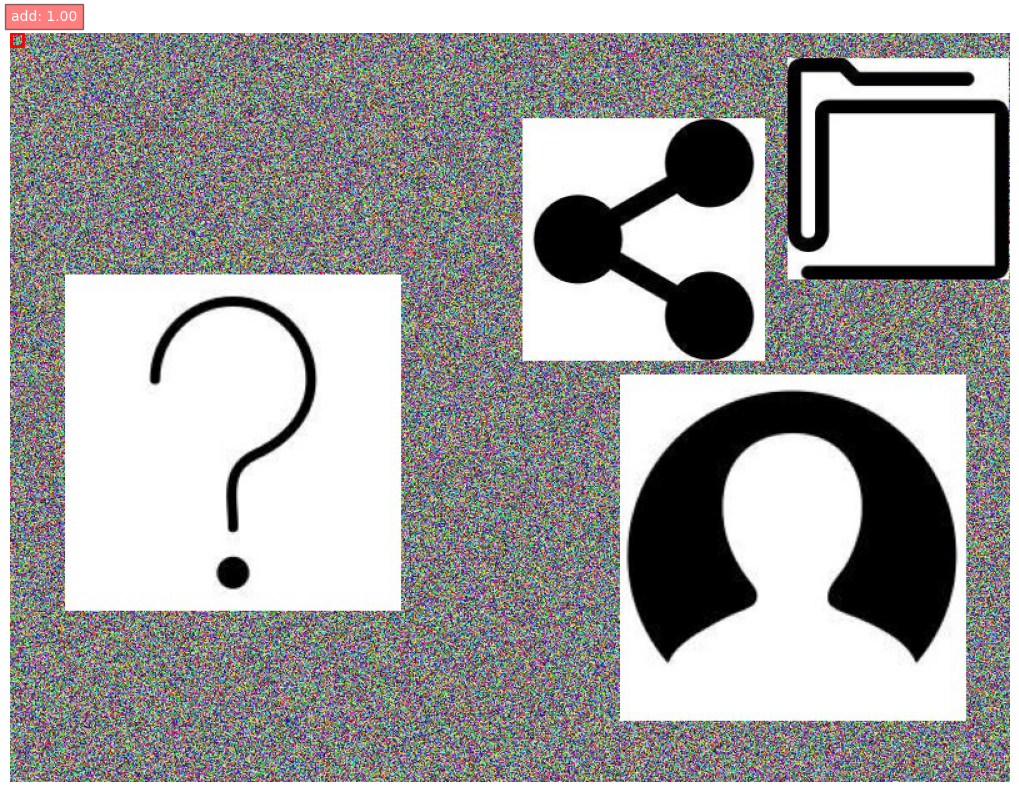

Detected objects:
add: 1.00


In [40]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json

def get_faster_rcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def predict(model, image_path, device, threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(img_tensor)

    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()

    high_conf_boxes = pred_boxes[pred_scores >= threshold]
    high_conf_labels = pred_labels[pred_scores >= threshold]
    high_conf_scores = pred_scores[pred_scores >= threshold]

    return high_conf_boxes, high_conf_labels, high_conf_scores

def display_prediction(image_path, boxes, labels, scores, class_names):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        class_name = class_names[labels[i]]
        ax.text(xmin, ymin - 10, f'{class_name}: {scores[i]:.2f}', color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set up your model
    num_classes = 106  # 106 classes + background
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_faster_rcnn_model(num_classes)
    model.load_state_dict(torch.load('model_fasterrcnn.pth'))
    model.to(device)

    # Load class names
    dataset_root = './'
    class_names = ['background'] + sorted(os.listdir(os.path.join(dataset_root, 'dataset')))

    # Path to the image you want to predict
    image_path = './test.jpg'

    # Perform prediction
    boxes, labels, scores = predict(model, image_path, device, threshold=0.5)

    # Display the results
    display_prediction(image_path, boxes, labels, scores, class_names)

    # Print the results
    print("Detected objects:")
    for label, score in zip(labels, scores):
        print(f"{class_names[label]}: {score:.2f}")